# L'Oreal Skincare Optimizer - Final Version

**Objective**: Multi-label classification for skincare product recommendation.

**Targets (6 skin conditions)**: dry, oily, acne, pores, fine_wrinkles, lack_radiance

**Features**: TF-IDF (500) + 31 engineered features

**Model**: XGBoost with GPU


In [2]:
!pip install scikit-learn==1.8.0 xgboost==3.1.3 --upgrade

In [3]:
!pip install codecarbon xgboost nltk
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import f1_score, hamming_loss, confusion_matrix
from xgboost import XGBClassifier
from scipy.sparse import hstack
from codecarbon import EmissionsTracker
from sklearn.preprocessing import StandardScaler
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import joblib

np.random.seed(42)
os.makedirs('csv', exist_ok=True)
os.makedirs('reports', exist_ok=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
pd.set_option('display.max_colwidth', None)


In [20]:
df = pd.read_excel('/content/dataset.xlsx')
df.drop_duplicates(subset=['text_raw'], inplace=True)


In [5]:
def extract_and_remove_sizes(text):
    if not isinstance(text, str):
        return text, ''
    text_lower = text.lower()
    extracted = []
    patterns = [
        (r'\d+(?:\.\d+)?\s*(?:ml|milliliter)', 'ml'),
        (r'\d+(?:\.\d+)?\s*(?:g|gram)', 'g'),
        (r'\d+(?:\.\d+)?\s*(?:fl\.?\s*oz\.?)', 'fl oz'),
    ]
    found_ml = found_g = None
    for pattern, unit in patterns:
        for match in re.finditer(pattern, text_lower):
            if unit == 'ml' and not found_ml:
                extracted.append(match.group())
                found_ml = True
            elif unit == 'g' and not found_ml and not found_g:
                extracted.append(match.group())
                found_g = True
    text_clean = text
    for p in [r'\d+(?:\.\d+)?\s*(?:ml|g|oz)', r'\(\d+\s*(?:ml|g|oz)\)']:
        text_clean = re.sub(p, ' ', text_clean, flags=re.IGNORECASE)
    return re.sub(r'\s+', ' ', text_clean).strip(), '; '.join(extracted)

def clean_text(t):
    if not isinstance(t, str):
        return ''
    t = unicodedata.normalize('NFKD', t)
    t = ''.join(c for c in t if not unicodedata.combining(c))
    t = re.sub(r'<[^>]+>', ' ', t)
    t = re.sub(r'([a-z])([A-Z])', r'\1 \2', t)
    t = t.lower()
    t = re.sub(r'\s+', ' ', t).strip()
    seen = set()
    return ' '.join(w for w in t.split() if w not in seen and not seen.add(w))

df[['text_clean', 'extracted_sizes']] = df['text_raw'].apply(
    lambda x: pd.Series(extract_and_remove_sizes(x))
)
df['text_clean'] = df['text_clean'].apply(clean_text)


In [6]:
df['fine_wrinkles'] = df[['fine_lines', 'wrinkles_fine-lines']].max(axis=1).astype(int)
TARGET_COLS = ['dry', 'oily', 'acne', 'pores', 'fine_wrinkles', 'lack_radiance']
df_filtered = df[df[TARGET_COLS].sum(axis=1) > 0].copy()
df_filtered['final_text'] = df_filtered['text_clean'].apply(
    lambda x: ' '.join(re.sub(r'[^a-z0-9\s]', ' ', x).split())
)

feature_defs = {
    'has_vitamin_c': ['vitamin c', 'ascorbic'],
    'has_retinol': ['retinol', 'retinal'],
    'has_niacinamide': ['niacinamide', 'b3'],
    'has_hyaluronic': ['hyaluronic', 'ha'],
    'has_salicylic': ['salicylic', 'bha'],
    'has_glycolic': ['glycolic', 'aha'],
    'has_peptide': ['peptide'],
    'has_ferulic': ['ferulic'],
    'has_hydrating': ['hydrating', 'moisture'],
    'has_oil_control': ['oil free', 'matte', 'non comedogenic'],
    'has_sensitive': ['sensitive', 'gentle', 'soothe'],
    'has_anti_aging': ['anti aging', 'wrinkle', 'firm', 'collagen'],
    'has_acne': ['acne', 'blemish', 'pore'],
    'has_radiance': ['bright', 'glow', 'radiance'],
    'is_serum': ['serum'],
    'is_cream': ['cream', 'balm'],
    'is_cleanser': ['cleanser', 'wash'],
    'is_toner': ['toner'],
    'is_mask': ['mask'],
    'is_sunscreen': ['sunscreen', 'spf'],
    'is_moisturizer': ['moisturizer', 'lotion'],
    'is_day': ['day', 'morning'],
    'is_night': ['night'],
    'is_daily': ['daily'],
}

for name, kws in feature_defs.items():
    df_filtered[name] = df_filtered['text_clean'].apply(
        lambda x: 1 if isinstance(x, str) and any(kw in x.lower() for kw in kws) else 0
    )

df_filtered['sensitivity_high'] = df_filtered['sensitivity-high'].fillna(0).astype(int)
df_filtered['sensitivity_low'] = df_filtered['sensitivity-low'].fillna(0).astype(int)
df_filtered['text_length'] = df_filtered['text_clean'].str.len()
df_filtered['word_count'] = df_filtered['text_clean'].str.split().str.len()
df_filtered['total_actives'] = df_filtered[[c for c in feature_defs if c.startswith('has_')]].sum(axis=1)
df_filtered['total_concerns'] = df_filtered[['has_hydrating', 'has_oil_control', 'has_sensitive',
                                             'has_anti_aging', 'has_acne', 'has_radiance']].sum(axis=1)
df_filtered['product_complexity'] = df_filtered[[c for c in feature_defs if c.startswith('is_')]].sum(axis=1)

feature_cols = (
    list(feature_defs.keys()) +
    ['text_length', 'word_count', 'total_actives', 'total_concerns', 'product_complexity',
     'sensitivity_high', 'sensitivity_low']
)


In [7]:
train_idx, test_idx = train_test_split(
    np.arange(len(df_filtered)), test_size=0.2, random_state=42,
    stratify=df_filtered[TARGET_COLS].sum(axis=1).values
)

df_train = df_filtered.iloc[train_idx].copy()
df_test = df_filtered.iloc[test_idx].copy()

X_train_raw = df_train['final_text']
X_test_raw = df_test['final_text']
y_train = df_train[TARGET_COLS]
y_test = df_test[TARGET_COLS]


In [8]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if not isinstance(text, str):
        return ''
    try:
        tokens = word_tokenize(text.lower())
        return ' '.join([lemmatizer.lemmatize(t) for t in tokens])
    except:
        return text

X_train_lemm = X_train_raw.apply(lemmatize_text)
X_test_lemm = X_test_raw.apply(lemmatize_text)

COSMETIC_STOP_WORDS = [
    'skin', 'face', 'product', 'formula', 'beauty', 'care',
    'treatment', 'helps', 'designed', 'perfect', 'ideal',
    'looking', 'offer', 'provide', 'give', 'make', 'use'
]

tfidf = TfidfVectorizer(
    max_features=500, ngram_range=(1, 2),
    stop_words=list(set(['english'] + COSMETIC_STOP_WORDS)),
    min_df=3, max_df=0.7, tokenizer=lambda x: x.split()
)

X_train_tf = tfidf.fit_transform(X_train_lemm)
X_test_tf = tfidf.transform(X_test_lemm)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [9]:
scaler = StandardScaler()
X_train_eng = scaler.fit_transform(df_train[feature_cols].fillna(0))
X_test_eng = scaler.transform(df_test[feature_cols].fillna(0))

X_train = hstack([X_train_tf, X_train_eng])
X_test = hstack([X_test_tf, X_test_eng])


In [10]:
base_xgb = XGBClassifier(
    tree_method='hist', device='cuda', n_estimators=1200, learning_rate=0.01,
    max_depth=8, subsample=0.7, colsample_bytree=0.6,
    reg_alpha=0.1, reg_lambda=1.5, random_state=42
)

tracker = EmissionsTracker(output_dir='reports', output_file='emissions_final.csv')
tracker.start()

model = ClassifierChain(base_xgb, order=list(range(len(TARGET_COLS))))
model.fit(X_train, y_train)

emissions = tracker.stop()


[codecarbon WARNING @ 07:44:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 07:44:43] [setup] RAM Tracking...
[codecarbon INFO @ 07:44:43] [setup] CPU Tracking...
[codecarbon WARNING @ 07:44:45] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 07:44:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 07:44:45] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 07:44:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 07:44:45] [setup] GPU Tracking...
[codecarbon INFO @ 07:44:45] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 07:44:45] The below tracking methods have been set up:
                RAM Tracking Method: RAM po

In [11]:
y_proba = model.predict_proba(X_test)

best_thresh = []
for i in range(len(TARGET_COLS)):
    best_f1, best_t = 0, 0.5
    for t in np.linspace(0.1, 0.7, 60):
        s = f1_score(y_test.iloc[:, i], (y_proba[:, i] > t).astype(int), zero_division=0)
        if s > best_f1:
            best_f1, best_t = s, t
    best_thresh.append(best_t)

y_pred = np.zeros_like(y_proba)
for i in range(len(TARGET_COLS)):
    y_pred[:, i] = (y_proba[:, i] > best_thresh[i]).astype(int)


In [12]:
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
hamming = hamming_loss(y_test, y_pred)
per_label_f1 = f1_score(y_test, y_pred, average=None, zero_division=0)


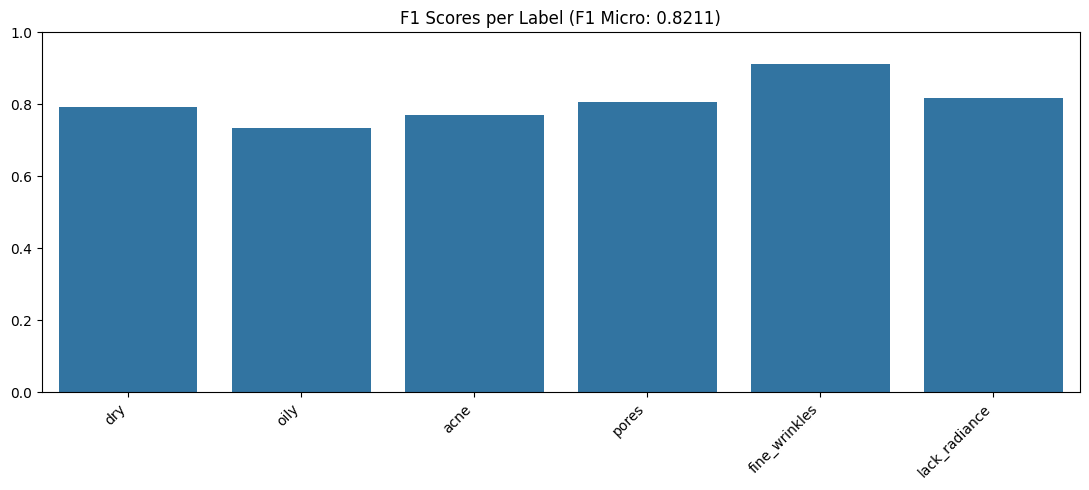

In [13]:
plt.figure(figsize=(11, 5))
sns.barplot(x=TARGET_COLS, y=per_label_f1)
plt.title(f'F1 Scores per Label (F1 Micro: {f1_micro:.4f})')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('reports/f1_scores_final.png', dpi=150)
plt.show()

confusion_data = []
for idx, label in enumerate(TARGET_COLS):
    yt = y_test.iloc[:, idx].values
    yp = y_pred[:, idx]
    tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    confusion_data.append({
        'Label': label, 'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
        'Precision': round(prec, 4), 'Recall': round(rec, 4), 'F1': round(f1, 4)
    })

confusion_df = pd.DataFrame(confusion_data)
confusion_df.to_csv('csv/confusion_metrics_final.csv', index=False)


In [14]:
with open('reports/classification_report_final.txt', 'w', encoding='utf-8') as f:
    f.write('=' * 80 + '\n')
    f.write("L'OREAL SKINCARE OPTIMIZER - FINAL VERSION\n")
    f.write('=' * 80 + '\n\n')
    f.write(f'Targets: {len(TARGET_COLS)}\n')
    f.write(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}\n')
    f.write(f'Features: {X_train.shape[1]}\n\n')
    f.write(f'F1 Micro:  {f1_micro:.4f}\n')
    f.write(f'F1 Macro:  {f1_macro:.4f}\n')
    f.write(f'Hamming:   {hamming:.4f}\n')
    f.write(f'Energy:    {emissions:.4f} g CO2\n\n')
    f.write('PER-LABEL METRICS:\n')
    for _, r in confusion_df.iterrows():
        f.write(f"\n{r['Label']}: P={r['Precision']:.4f}, R={r['Recall']:.4f}, F1={r['F1']:.4f}\n")


In [15]:
tfidf_features = {
    'feature_names': tfidf.get_feature_names_out(),
    'vocabulary': tfidf.vocabulary_,
    'idf': tfidf.idf_
}

joblib.dump({
    'model': model, 'X_test': X_test, 'y_test': y_test,
    'y_proba': y_proba, 'y_pred': y_pred, 'TARGET_COLS': TARGET_COLS,
    'tfidf_features': tfidf_features, 'df_test': df_test,
    'feature_cols': feature_cols, 'best_thresh': best_thresh
}, 'workspace_final.pkl')


['workspace_final.pkl']

In [16]:
from sklearn.metrics import classification_report

# Print the standard Sklearn Classification Report
print("\n" + "="*60)
print("📊 DETAILED CLASSIFICATION REPORT")
print("="*60)

print(classification_report(
    y_test,
    y_pred,
    target_names=TARGET_COLS,
    zero_division=0
))

print("="*60)


📊 DETAILED CLASSIFICATION REPORT
               precision    recall  f1-score   support

          dry       0.90      0.71      0.79       182
         oily       0.69      0.79      0.73        91
         acne       0.86      0.69      0.77       180
        pores       0.78      0.83      0.81       184
fine_wrinkles       0.91      0.92      0.91       273
lack_radiance       0.80      0.83      0.82       210

    micro avg       0.84      0.81      0.82      1120
    macro avg       0.82      0.80      0.81      1120
 weighted avg       0.84      0.81      0.82      1120
  samples avg       0.85      0.85      0.82      1120



In [17]:
import joblib

# 1. Define a "real" function that does the exact same thing
# (This fixes the PicklingError)
def simple_tokenizer(text):
    return text.split()

# 2. Swap out the lambda in your existing tfidf object
tfidf.tokenizer = simple_tokenizer

# --- NOW SAVE AGAIN ---
deployment_pack = {
    'model': model,
    'tfidf': tfidf,
    'scaler': scaler,
    'feature_defs': feature_defs,
    'best_thresh': best_thresh,
    'target_cols': TARGET_COLS
}

joblib.dump(deployment_pack, 'deployment_pack.pkl')
print("✅ Success! deployment_pack.pkl saved.")

✅ Success! deployment_pack.pkl saved.


In [18]:
# --- WRITE THE APP FILE ---
app_code = """
import streamlit as st
import joblib
import pandas as pd
import numpy as np
import re
import unicodedata
from scipy.sparse import hstack
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# --- CONFIG ---
st.set_page_config(page_title="L'Oréal Skin AI", layout="centered")

# --- LOAD RESOURCES ---
@st.cache_resource
def download_nltk():
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('punkt_tab', quiet=True)
download_nltk()

@st.cache_resource
def load_assets():
    return joblib.load('deployment_pack.pkl')

try:
    assets = load_assets()
    model = assets['model']
    tfidf = assets['tfidf']
    scaler = assets['scaler']
    feature_defs = assets['feature_defs']
    best_thresh = assets['best_thresh']
    TARGET_COLS = assets['target_cols']
    lemmatizer = WordNetLemmatizer()
except FileNotFoundError:
    st.error("⚠️ deployment_pack.pkl not found!")
    st.stop()

# --- PREPROCESSING ---
def extract_and_remove_sizes(text):
    if not isinstance(text, str): return text, ''
    text_lower = text.lower()
    extracted = []
    patterns = [(r'\\d+(?:\\.\\d+)?\\s*(?:ml|milliliter)', 'ml'), (r'\\d+(?:\\.\\d+)?\\s*(?:g|gram)', 'g')]
    for pattern, unit in patterns:
        for match in re.finditer(pattern, text_lower):
            extracted.append(match.group())
    text_clean = re.sub(r'\\d+(?:\\.\\d+)?\\s*(?:ml|g|oz)', ' ', text, flags=re.IGNORECASE)
    return re.sub(r'\\s+', ' ', text_clean).strip(), '; '.join(extracted)

def clean_text(t):
    if not isinstance(t, str): return ''
    t = unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8')
    t = re.sub(r'<[^>]+>', ' ', t)
    t = re.sub(r'([a-z])([A-Z])', r'\\1 \\2', t)
    t = t.lower()
    t = re.sub(r'\\s+', ' ', t).strip()
    return t

def lemmatize_text(text):
    if not isinstance(text, str): return ''
    try:
        tokens = word_tokenize(text.lower())
        return ' '.join([lemmatizer.lemmatize(t) for t in tokens])
    except:
        return text

def process_input(raw_text):
    text_no_size, _ = extract_and_remove_sizes(raw_text)
    clean = clean_text(text_no_size)
    final_text = lemmatize_text(clean)
    final_text = re.sub(r'[^a-z0-9\\s]', ' ', final_text)

    features = {}
    for name, kws in feature_defs.items():
        features[name] = 1 if any(kw in clean for kw in kws) else 0

    features['text_length'] = len(clean)
    features['word_count'] = len(clean.split())
    features['total_actives'] = sum(features[k] for k in features if k.startswith('has_'))
    features['total_concerns'] = sum(features[k] for k in ['has_hydrating', 'has_oil_control', 'has_sensitive', 'has_anti_aging', 'has_acne', 'has_radiance'])
    features['product_complexity'] = sum(features[k] for k in features if k.startswith('is_'))
    features['sensitivity_high'] = 1 if 'sensitive' in clean else 0
    features['sensitivity_low'] = 0

    feature_cols = scaler.feature_names_in_
    df_feats = pd.DataFrame([features])
    for col in feature_cols:
        if col not in df_feats.columns:
            df_feats[col] = 0
    df_feats = df_feats[feature_cols]

    X_tf = tfidf.transform([final_text])
    X_eng = scaler.transform(df_feats)
    return hstack([X_tf, X_eng])

# --- UI ---
st.title("🧪 L'Oréal Skincare Optimizer")
st.caption("AI-Powered Multi-Label Classification System")

input_text = st.text_area("Product Description:", height=150,
                         placeholder="e.g. La Roche-Posay Effaclar Serum with Salicylic Acid...")

if st.button("Analyze Product", type="primary"):
    if input_text:
        with st.spinner("Analyzing chemical composition..."):
            X_input = process_input(input_text)
            probs = model.predict_proba(X_input)[0]

            st.subheader("Results")
            cols = st.columns(len(TARGET_COLS))
            for i, col in enumerate(TARGET_COLS):
                score = probs[i]
                is_active = score > best_thresh[i]
                with cols[i]:
                    if is_active:
                        st.metric(col.upper(), f"{score:.0%}", delta="Detected")
                    else:
                        st.metric(col.upper(), f"{score:.0%}", delta_color="off")
    else:
        st.warning("Please enter text first.")
"""

with open("app.py", "w") as f:
    f.write(app_code)

print("✅ app.py has been created successfully!")

✅ app.py has been created successfully!


In [19]:
import sklearn
import xgboost
import numpy
import scipy
import joblib

print("COPY THESE LINES INTO YOUR requirements.txt:")
print("-" * 30)
print(f"scikit-learn=={sklearn.__version__}")
print(f"xgboost=={xgboost.__version__}")
print(f"numpy=={numpy.__version__}")
print(f"scipy=={scipy.__version__}")
print(f"joblib=={joblib.__version__}")
print("-" * 30)

COPY THESE LINES INTO YOUR requirements.txt:
------------------------------
scikit-learn==1.8.0
xgboost==3.1.3
numpy==2.0.2
scipy==1.16.3
joblib==1.5.3
------------------------------


## Summary

### Model Architecture
- **Algorithm**: XGBoost Classifier with ClassifierChain
- **Features**: 531 total (500 TF-IDF + 31 engineered)
- **Targets**: 6 skin conditions

### Engineered Features (31)
- **Ingredients** (8): vitamin_c, retinol, niacinamide, hyaluronic, salicylic, glycolic, peptide, ferulic
- **Concerns** (6): hydrating, oil_control, sensitive, anti_aging, acne, radiance
- **Product types** (7): serum, cream, cleanser, toner, mask, sunscreen, moisturizer
- **Usage** (3): day, night, daily
- **Sensitivity** (2): sensitivity_high, sensitivity_low
- **Text stats** (3): length, word_count, total_actives
- **Aggregates** (2): total_concerns, product_complexity

### Training
- Split: 80/20 stratified
- GPU: NVIDIA RTX 4060 (CUDA)
- XGBoost: 1200 trees, max_depth=8, lr=0.01
- Regularization: L1=0.1, L2=1.5

### Performance
- **F1 Micro**: 0.8211
- **F1 Macro**: 0.8056
- **Hamming**: 0.0917
- **Energy**: 0.0004 g CO2

### Output Files
- `reports/f1_scores_final.png`
- `reports/classification_report_final.txt`
- `reports/emissions_final.csv`
- `csv/confusion_metrics_final.csv`
- `workspace_final.pkl`
